In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tqdm import tqdm
from sympy import Symbol
from pathlib import Path
import centrex_TlF as centrex
import matplotlib.pyplot as plt

import sys
sys.path.append("../../..")
from utils.plot_utils import set_fontsize

In [2]:
nprocs = 6

# Γ
Γ = 1.56e6*2*np.pi

# TlF temperature
T = 6.3

# Define all involved states

# ground state J levels
ground_Js = [0,2]

# excited state quantum numbers
excited_Js = [1]
excited_F1s = [3/2]
excited_Fs= [2]
excited_Ps = [-1]

# Settings for transitions

# min and max J level to look for mixing in the B state
excited_Jmin = 1
excited_Jmax = 2


# main laser transition R(0) F'=2 F1'=3/2

ground_main_approx = 1*centrex.CoupledBasisState(J=0,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', 
                                         P = (-1)**0, Omega = 0)
excited_main_approx = 1*centrex.CoupledBasisState(J=1,
                                          F1=3/2,
                                          F=2,
                                          mF=0,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)
# ground laser J
laser_J = [0]

transitions = [{'ground main approx': ground_main_approx, 
                'excited main approx': excited_main_approx,
                'ground states approx': 1*centrex.states.generate_coupled_states_ground(laser_J),
                'excited states approx': 1*centrex.states.generate_coupled_states_excited(
                                                excited_Js, excited_Fs, excited_F1s, excited_Ps),
                'main polarization': np.array([0,0,1]),
                'polarizations': [np.array([0,0,1]), np.array([1,0,0])],
                'polarization symbols': [Symbol("Plz"), Symbol("Plx")],
                'Ω symbol': Symbol('Ωl', complex = True),
                'Δ symbol': Symbol('δl'),
                'description': "laser transition"
               }]

In [3]:
# specify states to combine into a single level 
# e.g. only decay to these states and not interested in population distribution there
slice_compact = np.s_[4:24]

### Specifying parameters and the ode function preamble
Allows for setting parameters to be time dependent (e.g. sin(t), cos(t))

In [4]:
# order of parameters in p
parameters = ['Ωl', 'δl', 'ωp', 'ϕp', 'y0', 'vy', 'vz', 'μzlaser', 'σylaser', 'σzlaser', 'β', 'ωphase']

In [5]:
preamble = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩl = complex(p[1])
\t\tδl = p[2]
\t\tωp = p[3]
\t\tϕp = p[4]
\t\ty0 = p[5]
\t\tvy = p[6]
\t\tvz = p[7]
\t\tμzlaser = p[8]
\t\tσylaser = p[9]
\t\tσzlaser = p[10]
\t\tβ = p[11]
\t\tωphase = p[12]
\t\tΩl = Ωl * gaussian_2d(vz*t, y0+vy*t, 1., μzlaser, 0., σzlaser, σylaser) * phase_modulation(t, β, ωphase)

\t\tΩlᶜ = conj(Ωl)

\t\tPl = sin(ωp*t + ϕp)
\t\tPlx = (1-Pl)/2
\t\tPlz = (1+Pl)/2
"""

In [6]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = Γ
odepars.ωp = Γ
odepars

odeParameters(Ωl: 9.80e+06, δl: 0.00e+00, ωp: 9.80e+06, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 0.00e+00, μzlaser: 0.00e+00, σylaser: 0.00e+00, σzlaser: 0.00e+00, β: 0.00e+00, ωphase: 0.00e+00)

## Start calculations for Hamiltonian and transitions

In [7]:
%%time 
ground_states_approx = centrex.states.generate_coupled_states_ground(ground_Js)
excited_states_approx = centrex.states.generate_coupled_states_excited(excited_Js, excited_Fs, 
                                                                       excited_F1s, excited_Ps)

ground_states, excited_states, QN, H_int, V_ref_int = centrex.hamiltonian.generate_total_reduced_hamiltonian(
                                            ground_states_approx, excited_states_approx)

Wall time: 9.57 s


In [8]:
%%time
couplings = []
for transition in transitions:
    coupling = centrex.couplings.generate_coupling_field(
                                        transition['ground main approx'],
                                        transition['excited main approx'],
                                        transition['ground states approx'],
                                        transition['excited states approx'],
                                        H_int, QN, V_ref_int, 
                                        pol_main = transition['main polarization'],
                                        pol_vec = transition['polarizations'],
                                        nprocs = nprocs)
    couplings.append(coupling)

Wall time: 9.57 s


In [9]:
%%time
H_symbolic = centrex.lindblad.generate_total_symbolic_hamiltonian(QN, H_int, couplings, transitions, 
                                                                slice_compact = slice_compact)

Wall time: 171 ms


In [10]:
%%time
C_array = centrex.couplings.collapse_matrices(QN, ground_states, excited_states, gamma = Γ, 
                                            slice_compact = slice_compact)
system = centrex.lindblad.generate_system_of_equations_symbolic(H_symbolic, C_array, progress = False, fast = True)

Wall time: 1.1 s


In [11]:
%%time
# convert matrix to system of equations code
code_lines = centrex.lindblad.system_of_equations_to_lines(system, nprocs = nprocs)

Wall time: 6.22 s


In [12]:
QNcompact = [QN[idx] for idx in range(len(QN)) if idx not in range(slice_compact.start+1, slice_compact.stop)]
s = QNcompact[slice_compact.start]
s = s.find_largest_component()
s.F = None
s.F1 = None
s.mF = None
QNcompact[slice_compact.start] = 1*s

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [13]:
# import julia
# julia.install()

In [14]:
from julia import Main
centrex.lindblad.initialize_julia(nprocs = nprocs)

_ = centrex.lindblad.generate_ode_fun_julia(preamble, code_lines)

# generate initial conditions
ρ_ini = centrex.utils.generate_population_states([1,2,3], H_symbolic.shape[0])
centrex.lindblad.setup_variables_julia(Γ, ρ_ini)
odepars.generate_p_julia()

Initialized Julia with 6 processes


In [15]:
Main.eval("""
@everywhere function gaussian_2d(x::Float64, y::Float64, a::Float64, μx::Float64, μy::Float64, σx::Float64, σy::Float64)::Float64
    a.*exp(- ((x-μx)^2 / (2 * σx*σx) + (y-μy)^2 / (2 * σy*σy)))
end

@everywhere function phase_modulation(t::Float64, β::Float64, ω::Float64)
    return exp(1im*β*sin(ω*t))
end
""")

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [333]:
odepars = centrex.lindblad.odeParameters(parameters)
odepars.Ωl = 0.18*Γ
odepars.ωp = Γ
odepars.σylaser = 8e-3
odepars.σzlaser = 8e-3
odepars.μzlaser = 4*odepars.σzlaser
odepars.y0 = 0
odepars.vz = 184
odepars.vy = 0
odepars.β = 3.8
odepars.ωphase = 2*np.pi*1.6e6
odepars.generate_p_julia()
print(odepars.to_units_Γ(Γ))

odeParameters(Ωl: 0.18, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 3.20e-02, σylaser: 8.00e-03, σzlaser: 8.00e-03, β: 3.80e+00, ωphase: 1.03)


In [334]:
Main.eval(f"""
tspan = (0.0, {8*odepars.σzlaser / odepars.vz})
prob = ODEProblem(Lindblad_rhs!,ρ,tspan,p)
""");

In [335]:
Main.eval("using InteractiveUtils")
Main.eval("using BenchmarkTools")

In [336]:
%%time
Main.du = np.zeros(ρ_ini.shape, dtype = complex)
Main.eval("@code_warntype Lindblad_rhs!(du, ρ, p, 0.0);");

Wall time: 2.32 s


In [337]:
%%time
Main.eval("@btime Lindblad_rhs!(du, ρ, p, 0.0);");

Wall time: 2.66 s


In [338]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-7, reltol = 1e-4, progress = false);
tmp = 0
""");

Wall time: 100 ms


0

In [339]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t")

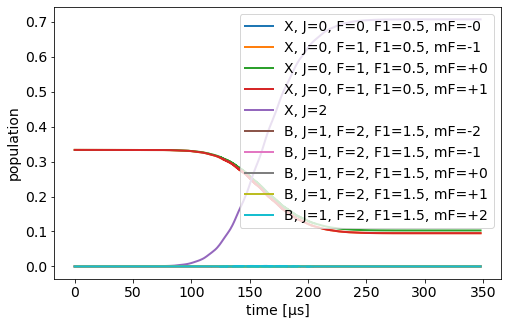

In [340]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx in range(0,len(pop_results)):
        s = QNcompact[idx].find_largest_component()
        if s.F is None:
            label = f'{s.electronic_state}, J={s.J}'
        else:
            label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

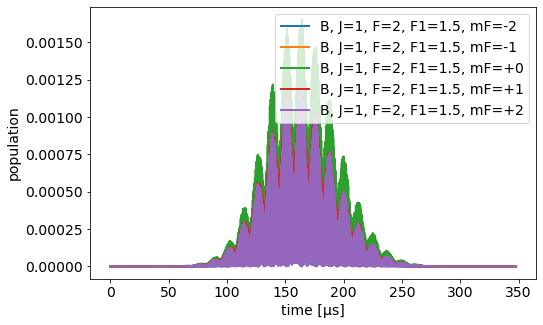

In [341]:
fig, ax = plt.subplots(figsize = (8,5))

for idx, pop in enumerate(pop_results):
    ls = '-'
    if idx >= H_symbolic.shape[0] - len(excited_states):
        s = QNcompact[idx].find_largest_component()
        label = f'{s.electronic_state}, J={s.J}, F={s.F:.0f}, F1={s.F1}, mF={s.mF:+.0f}'
        ax.plot(t_array*1e6, pop, lw = 2, label = label, ls = ls)
#         ax.plot(t_array*1e6, pop, lw = 2, label = f"ρ$_{{{idx},{idx}}}$", ls = ls)

ax.set_xlabel('time [μs]')
ax.set_ylabel('population')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Scan detuning

In [342]:
odepars.Ωl = 0.4*Γ
odepars.ωp = 1*Γ
print(odepars.to_units_Γ(Γ))
odepars.generate_p_julia()

odeParameters(Ωl: 0.40, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 3.20e-02, σylaser: 8.00e-03, σzlaser: 8.00e-03, β: 3.80e+00, ωphase: 1.03)


In [343]:
# ρ_ini = centrex.utils.generate_thermal_J(ground_Js, len(excited_states), T, normalized = True, 
#                                          slice_compact = slice_compact)
ρ_ini = centrex.utils.generate_population_states([0,1,2,3], H_symbolic.shape[0])
Main.ρ_ini = ρ_ini
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [344]:
δls = np.linspace(-5,5,101)*Γ

In [345]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_1D(odepars, 'δl', δls)

In [346]:
# generate the output_func to transform the ode solution after integration
centrex.lindblad.setup_state_integral_calculation([6,7,8,9,10])

In [347]:
Main.eval(f"""
tspan = (0.0, {8*odepars.σzlaser / odepars.vz})
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [348]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [349]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-8, reltol = 1e-5)
sim.elapsedTime
""")

6.2153769

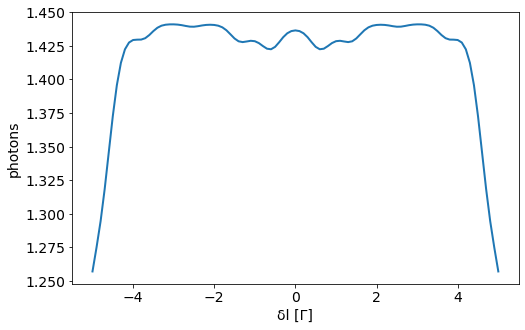

In [350]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Main.params/Main.Γ, np.asarray(Main.sim)*Γ, lw = 2)

ax.set_xlabel('δl [Γ]')
ax.set_ylabel('photons')

set_fontsize(ax, 14)

## Scan detuning and laser power before rotational cooling 

In [351]:
ρ_ini = centrex.utils.generate_thermal_J([0,1,2,3], len(excited_states), T, normalized = True, 
                                         slice_compact = None)
ρ_ini = ρ_ini[:H_symbolic.shape[0],:H_symbolic.shape[0]]
ρ_ini[-len(excited_states):,-len(excited_states):] = 0
ρ_ini[4,4] = 0
Main.ρ_ini = ρ_ini
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [352]:
Ωls = centrex.utils.calculate_rabi_from_power_gaussian_beam(np.linspace(0,60e-3,51), 
                                                            np.abs(couplings[0]['main coupling'].real),
                                                            σx = 1e-2/2, σy = 1e-2/2)
δls = np.linspace(-3,3,101)*Γ

In [353]:
# generate the prob_func to remake the problem for each iteration
centrex.lindblad.setup_parameter_scan_ND(odepars, ['Ωl', 'δl'], [Ωls, δls])

In [354]:
# generate the output_func to transform the ode solution after integration
centrex.lindblad.setup_state_integral_calculation([6,7,8,9,10])

In [355]:
Main.eval(f"""
tspan = (0.0, {8*odepars.σzlaser / odepars.vz})
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [356]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [357]:
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(); trajectories = size(params)[1],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true)
sim.elapsedTime
""")

104.9153327

In [358]:
params = np.asarray(Main.params)
results = np.array(Main.eval("sim.u"))*Γ
lpower = centrex.utils.calculate_power_from_rabi_gaussian_beam(params[:,0], 
                                                               np.abs(couplings[0]['main coupling'].real),
                                                                σx = 1e-2/2, σy = 1e-2/2)

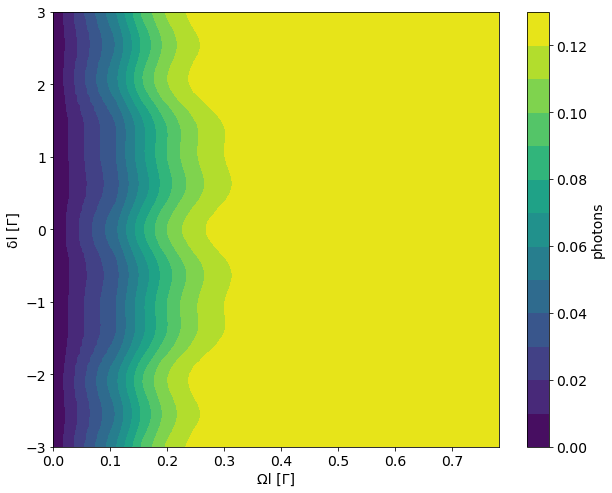

In [359]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(params[:,0]/Γ, params[:,1]/Γ, results, levels = 15)

cbar = fig.colorbar(tcf)
# ax.scatter(lpower*1e3, params[:,1]/Γ, color = 'k')

ax.set_xlabel('Ωl [Γ]')
ax.set_ylabel(r'δl [Γ]')
cbar.ax.set_ylabel('photons')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

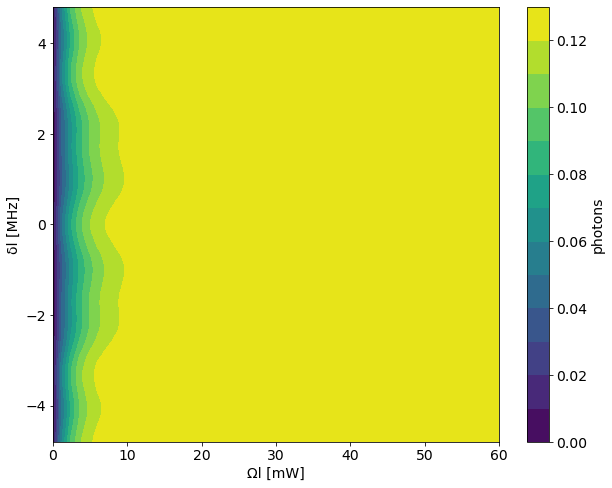

In [360]:
fig, ax = plt.subplots(figsize = (10,8))

tcf = ax.tricontourf(lpower*1e3, params[:,1]*1.6/Γ, results, levels = 15)

cbar = fig.colorbar(tcf)
# ax.scatter(lpower*1e3, params[:,1]/Γ, color = 'k')

ax.set_xlabel('Ωl [mW]')
ax.set_ylabel(r'δl [MHz]')
cbar.ax.set_ylabel('photons')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Setup with values from RC simulation, with initial thermal population

In [361]:
data_dir = Path('.').absolute().parent
fname = 'P2F1_RC_cooling_14pc_mploss.npy'
results_array = np.load(data_dir / fname)

In [362]:
# y0s is at the position of the RC laser, correct fot that in the next cell
δls, y0s, vys, vzs = results_array[:,[1,4,5,6]].T

In [363]:
# new y0 positions 1" in front of DET laser
in_to_m = 25.4e-3
distance_laser_rc = 21.75 * in_to_m - 0.01
distance_laser_lif = 38.30 * in_to_m - 0.01
y0s_start = (distance_laser_lif - distance_laser_rc-1*in_to_m)/vzs * vys + y0s
odepars.μzlaser = 25.4e-3

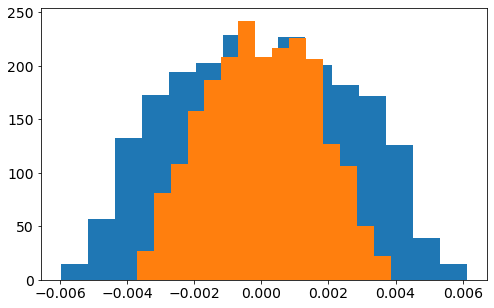

In [364]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(y0s_start, bins = 15)
ax.hist(y0s, bins = 15);

set_fontsize(ax, 14)

In [365]:
params = np.stack([δls, y0s_start, vys, vzs])
Main.params = params
Main.eval("@everywhere params = $params")

In [366]:
ρ_ini = centrex.utils.generate_thermal_J([0,1,2,3], len(excited_states), T, normalized = True, 
                                         slice_compact = None)
ρ_ini = ρ_ini[:H_symbolic.shape[0],:H_symbolic.shape[0]]
ρ_ini[4,4] = 0
ρ_ini[-len(excited_states):,-len(excited_states):] = 0
Main.ρ_ini = ρ_ini
Main.eval("@everywhere ρ_ini = $ρ_ini")

In [367]:
Main.eval(f"""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [368]:
# terminate integration 1" behind the detection laser
Main.eval("""
@everywhere function affect!(integrator)
    terminate!(integrator)
end
@everywhere condition(u,t,integrator) = integrator.p[7]*t > 50.8e-3
cb = DiscreteCallback(condition, affect!)
""");

In [369]:
odepars.Ωl = 0.5*Γ
odepars.ωl = 2*np.pi*1e6
print(odepars.to_units_Γ(Γ))
odepars.generate_p_julia()

odeParameters(Ωl: 0.50, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.54e-02, σylaser: 8.00e-03, σzlaser: 8.00e-03, β: 3.80e+00, ωphase: 1.03)


In [370]:
Main.eval(f"""
@everywhere function prob_func_prerc(prob,i,repeat)
    remake(prob,p=[{odepars.Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                    params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, {odepars.β}, {odepars.ωphase}])
end
""")

In [371]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob_prerc = EnsembleProblem(prob, prob_func = prob_func_prerc, output_func = output_func);
""");

In [372]:
Main.eval("""
@time sim = solve(ens_prob_prerc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
sim.elapsedTime
""")

59.5665802

In [373]:
results = np.array(Main.eval("sim.u"))*Γ

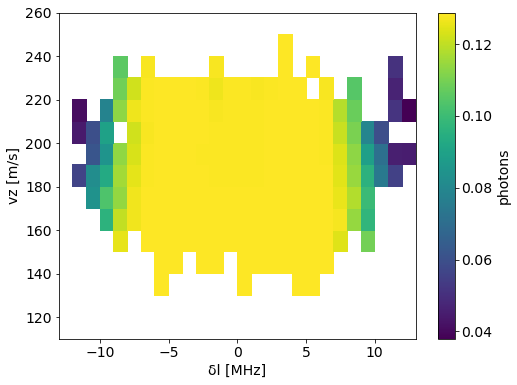

In [374]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = results
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('photons')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

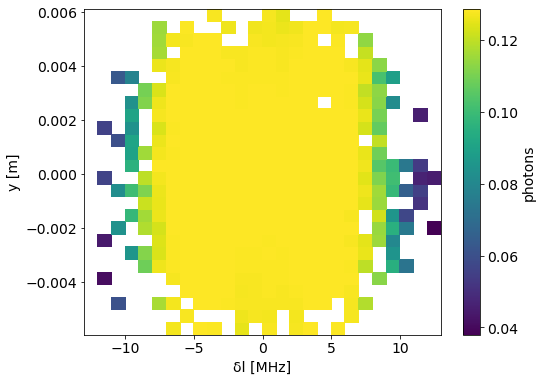

In [375]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(y0s_start.min(), y0s_start.max(),27)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[1,:]
z = results
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'y [m]')
cbar.ax.set_ylabel('photons')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

## Setup with values from RC simulation, with post-RC population

In [376]:
ρrc = []
for pop in results_array[:,-67:][:,:4]:
    _ρ = np.zeros(ρ_ini.shape, dtype = ρ_ini.dtype)
    np.fill_diagonal(_ρ[:4,:4], pop)
    ρrc.append(_ρ)

In [377]:
params = np.stack([δls, y0s_start, vys, vzs])
Main.params = params
Main.eval("@everywhere params = $params")
Main.ρrc = ρrc
Main.eval("@everywhere ρrc = $ρrc")

In [378]:
Main.eval(f"""
tspan = (0.0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [379]:
odepars.Ωl = 0.5*Γ
odepars.ωl = 2*np.pi*1e6
print(odepars.to_units_Γ(Γ))
odepars.generate_p_julia()

odeParameters(Ωl: 0.50, δl: 0.00, ωp: 1.00, ϕp: 0.00e+00, y0: 0.00e+00, vy: 0.00e+00, vz: 1.84e+02, μzlaser: 2.54e-02, σylaser: 8.00e-03, σzlaser: 8.00e-03, β: 3.80e+00, ωphase: 1.03)


In [380]:
Main.eval(f"""
@everywhere function prob_func_postrc(prob,i,repeat)
    remake(prob,p=[{odepars.Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                    params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, {odepars.β}, {odepars.ωphase}], u0 = ρrc[i])
end
""")

In [381]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob_postrc = EnsembleProblem(prob, prob_func = prob_func_postrc, output_func = output_func);
""");

In [382]:
Main.eval("""
@time sim = solve(ens_prob_postrc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
sim.elapsedTime
""")

74.0607345

In [383]:
results_RC = np.array(Main.eval("sim.u"))*Γ

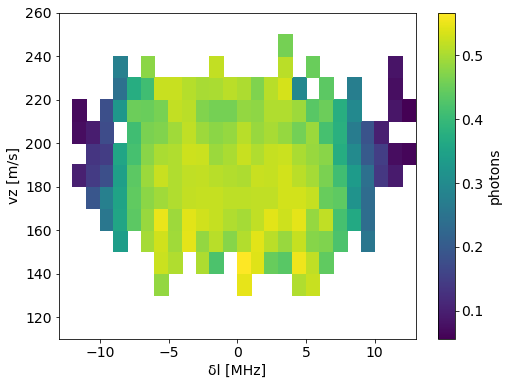

In [384]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = results_RC
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('photons')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

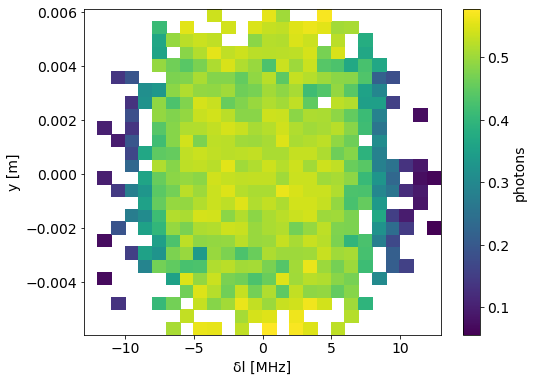

In [385]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(y0s_start.min(), y0s_start.max(),27)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[1,:]
z = results_RC
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'y [m]')
cbar.ax.set_ylabel('photons')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

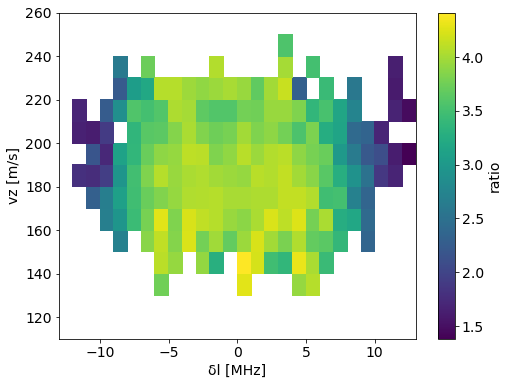

In [386]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(110, 260, 16)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[3,:]
z = results_RC/results
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = z, statistic = 'mean', bins = [xbins, ybins])
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'vz [m/s]')
cbar.ax.set_ylabel('ratio')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

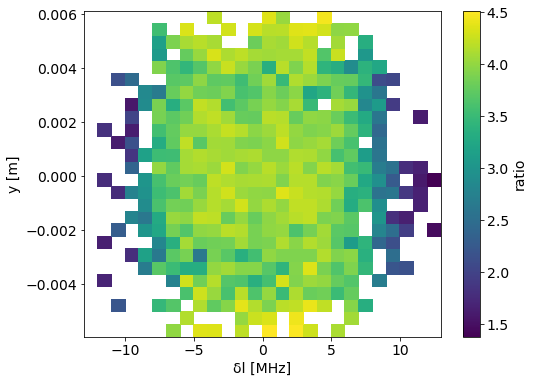

In [389]:
xbins = np.linspace(-13, 13, 27)
ybins = np.linspace(y0s_start.min(), y0s_start.max(),27)

from scipy.stats import norm, binned_statistic_2d

x = params[0,:]/Γ * 1.6
y = params[1,:]
statRC, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = results_RC, statistic = 'mean', bins = [xbins, ybins])
stat, x_edge, y_edge, bin_number = binned_statistic_2d(x,y,values = results, statistic = 'mean', bins = [xbins, ybins])

stat = statRC/stat
X, Y = np.meshgrid(x_edge,y_edge)
            
fig, ax = plt.subplots(figsize = (8,6))
cs = ax.pcolormesh(X, Y, stat.T)

cbar = fig.colorbar(cs)


ax.set_xlabel('δl [MHz]')
ax.set_ylabel(r'y [m]')
cbar.ax.set_ylabel('ratio')
set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [390]:
# apparent ratio
ratio_measured = results_RC.mean()/results.mean()
ratio_real = results_array[:,-67:][:,1:4].sum(axis = 1).mean()/np.diag(ρ_ini)[1:4].sum().real
print(f"ratio measured : {ratio_measured:.2f}")
print(f"ratio real : {ratio_real:.2f}") 
print(f"measured / real : {ratio_measured/ratio_real:.2f}")

ratio measured : 3.87
ratio real : 3.84
measured / real : 1.01


In [409]:
3*0.337/0.147 * (ratio_real - 1) + 1

20.519751587255165

In [404]:
results_array[:,-67:][:,0].mean()/np.diag(ρ_ini.real)[0]

20.456258059358003

## Scan Rabi rate

In [391]:
Ωls = centrex.utils.calculate_rabi_from_power_gaussian_beam(np.linspace(0,200e-3,21), 
                                                            np.abs(couplings[0]['main coupling'].real),
                                                            σx = 1e-2/2, σy = 1e-2/2)

In [392]:
results_rc = []
results = []
for Ωl in tqdm(Ωls):    
    Main.eval(f"""
    @everywhere function prob_func_postrc(prob,i,repeat)
        remake(prob,p=[{Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                        params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, 
                        {odepars.β}, {odepars.ωphase}], u0 = ρrc[i])
    end
    """);
    
    Main.eval(f"""
    @everywhere function prob_func_prerc(prob,i,repeat)
        remake(prob,p=[{Ωl}, params[1,i], {odepars.ωp}, 0, params[2,i], params[3,i], 
                        params[4,i], {odepars.μzlaser}, {odepars.σylaser}, {odepars.σzlaser}, 
                        {odepars.β}, {odepars.ωphase}])
    end
    """);
    
    # setting up the EnsembleProblem with the earlier defined ODEProblem
    Main.eval("""
    ens_prob_postrc = EnsembleProblem(prob, prob_func = prob_func_postrc, output_func = output_func);
    ens_prob_prerc  = EnsembleProblem(prob, prob_func = prob_func_prerc, output_func = output_func);
    """);
    Main.eval("""
    @time sim = solve(ens_prob_prerc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
    """);
    pre_RC = np.array(Main.eval("sim.u"))*Γ
    Main.eval("""
    @time sim = solve(ens_prob_postrc, Tsit5(), EnsembleDistributed(); trajectories = size(params)[2],
            abstol = 1e-8, reltol = 1e-5, save_everystep = true, callback = cb)
    """);
    post_RC = np.array(Main.eval("sim.u"))*Γ
    results_rc.append(post_RC.mean())
    results.append(pre_RC.mean())

100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [47:38<00:00, 136.11s/it]


<ipython-input-393-22551e812b19>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(Ωls/Γ, results_rc/results, '.', ms = 12)


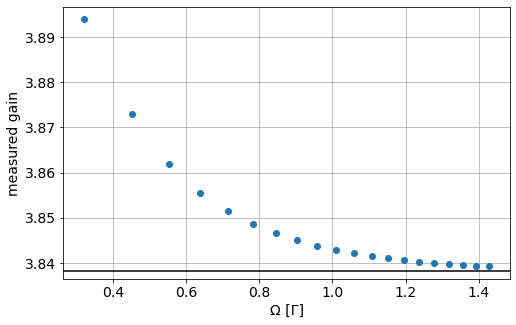

In [393]:
results_rc = np.asarray(results_rc)
results = np.asarray(results)
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Ωls/Γ, results_rc/results, '.', ms = 12)
ax.axhline(ratio_real, color = 'k')

ax.set_xlabel('Ω [Γ]')
ax.set_ylabel("measured gain")

ax.grid(True)

set_fontsize(ax, 14)

In [394]:
lpower = centrex.utils.calculate_power_from_rabi_gaussian_beam(Ωls, 
                                                               np.abs(couplings[0]['main coupling'].real),
                                                               σx = 1e-2/2, σy = 1e-2/2)

<ipython-input-395-5d621c6537d7>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(lpower*1e3, results_rc/results, '.', ms = 12, label = 'detected')


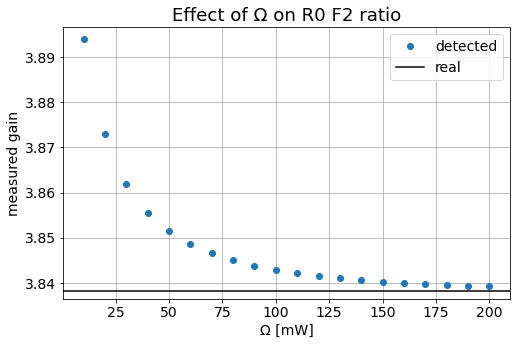

In [395]:
results_rc = np.asarray(results_rc)
results = np.asarray(results)
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(lpower*1e3, results_rc/results, '.', ms = 12, label = 'detected')
ax.axhline(ratio_real, color = 'k', label = 'real')

ax.set_xlabel('Ω [mW]')
ax.set_ylabel("measured gain")
ax.set_title('Effect of Ω on R0 F2 ratio')
ax.legend(fontsize = 14)

ax.grid(True)

set_fontsize(ax, 14)

<ipython-input-405-c72622d907f0>:5: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(lpower*1e3, 3*(0.337/0.147)*(results_rc/results - 1) + 1, '.', ms = 12, label = 'detected')


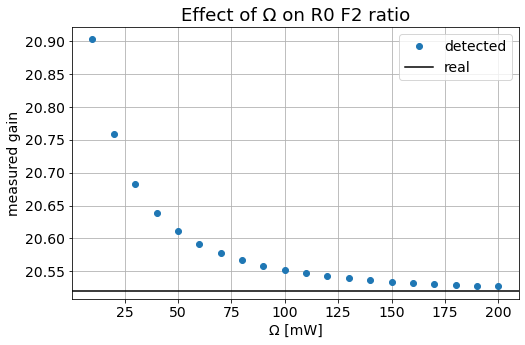

In [405]:
results_rc = np.asarray(results_rc)
results = np.asarray(results)
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(lpower*1e3, 3*(0.337/0.147)*(results_rc/results - 1) + 1, '.', ms = 12, label = 'detected')
ax.axhline(3*(0.337/0.147)*(ratio_real - 1) + 1, color = 'k', label = 'real')

ax.set_xlabel('Ω [mW]')
ax.set_ylabel("measured gain")
ax.set_title('Effect of Ω on R0 F2 ratio')
ax.legend(fontsize = 14)

ax.grid(True)

set_fontsize(ax, 14)

In [417]:
results_R0F2 = (results_rc/results).copy()
results_R0F1 = np.array([np.nan, 8.54780119, 8.28807724, 8.18451317, 8.13323003,
       8.10355222, 8.08436235, 8.07090601, 8.06087783, 8.05306447,
       8.04677512, 8.04159124, 8.03724649, 8.0335516 , 8.03036784,
       8.02758837, 8.02514104, 8.02296522, 8.02101516, 8.01926008,
       8.01766651])

<ipython-input-417-c57e14236583>:1: RuntimeWarning: invalid value encountered in true_divide
  results_R0F2 = (results_rc/results).copy()


In [418]:
results_R0F2

array([       nan, 3.89387062, 3.87293821, 3.86199174, 3.85556698,
       3.85145562, 3.84861736, 3.84657131, 3.84503325, 3.84385483,
       3.84292349, 3.84218258, 3.84157776, 3.8410805 , 3.84066626,
       3.84032265, 3.8400316 , 3.83978517, 3.83956792, 3.83939021,
       3.83923282])

In [419]:
# gain_F0 = results_array[:,-67:][:,0].mean()/ρ_ini[0,0].real
gain_F0 = 3*0.337/0.147 * (ratio_real - 1) + 1

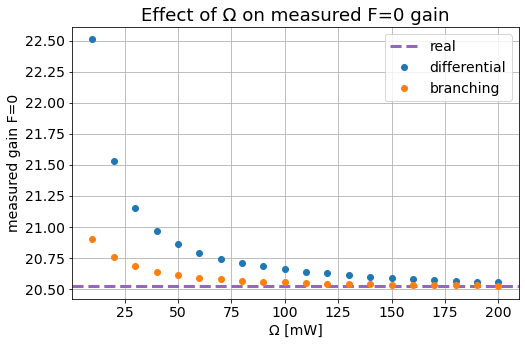

In [420]:
fig, ax = plt.subplots(figsize = (8,5))

ax.axhline(gain_F0, color = 'C4', lw = 3, label = 'real', ls = '--')
ax.plot(lpower*1e3, 4*results_R0F1 - 3*results_R0F2, '.', ms = 12, label = 'differential')
ax.plot(lpower*1e3, 3*(0.337/0.147)*(results_R0F2 - 1) + 1, '.', ms = 12, label = 'branching')

ax.set_title('Effect of Ω on measured F=0 gain')
ax.set_xlabel('Ω [mW]')
ax.set_ylabel("measured gain F=0")

ax.legend(fontsize = 14)
ax.grid(True)

set_fontsize(ax, 14)

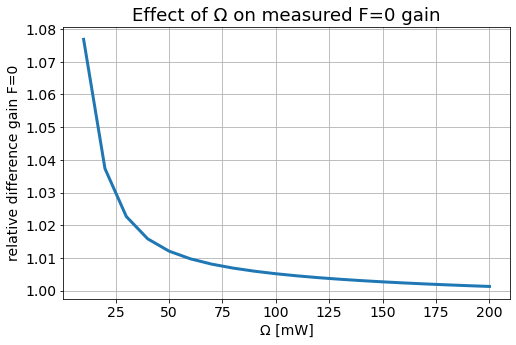

In [421]:
gainF0_diff = 4*results_R0F1 - 3*results_R0F2
gainF0_br = 3*(0.337/0.147)*(results_R0F2 - 1) + 1

fig, ax = plt.subplots(figsize = (8,5))

ax.plot(lpower*1e3, gainF0_diff/gainF0_br, lw = 3)

ax.set_title('Effect of Ω on measured F=0 gain')
ax.set_xlabel('Ω [mW]')
ax.set_ylabel("relative difference gain F=0")
ax.grid(True)

set_fontsize(ax, 14)